In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic


In [3]:
!pip install geopy


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic

In [5]:
# Load dataset
df = pd.read_csv("uber.csv")

In [6]:
# Display dataset information
print("Dataset Information:\n")
print(df.info())
print("\nDataset Head:\n")
print(df.head())

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None

Dataset Head:

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3

In [7]:
# 1. Pre-processing the dataset
# Convert 'pickup_datetime' to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Drop rows with missing values in 'pickup_datetime' and 'fare_amount'
df.dropna(subset=['pickup_datetime', 'fare_amount'], inplace=True)

# Remove negative and extremely high values in 'fare_amount' and 'passenger_count'
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

print(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].isnull().sum())

invalid_rows = df[
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)
]
print(invalid_rows)

lat_min, lat_max = -90.0, 90.0
lon_min, lon_max = -90.0, 90.0

df['pickup_longitude'] = df['pickup_longitude'].apply(lambda x: x if lon_min <= x <= lon_max else df['pickup_longitude'].median())
df['pickup_latitude'] = df['pickup_latitude'].apply(lambda x: x if lat_min <= x <= lat_max else df['pickup_latitude'].median())
df['dropoff_longitude'] = df['dropoff_longitude'].apply(lambda x: x if lon_min <= x <= lon_max else df['dropoff_longitude'].median())
df['dropoff_latitude'] = df['dropoff_latitude'].apply(lambda x: x if lat_min <= x <= lat_max else df['dropoff_latitude'].median())



# Calculate distance between pickup and dropoff points using geopy
def calculate_distance(row):
    try:
        return geodesic(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km
    except ValueError as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # or 0, depending on how you want to handle errors

df['distance_km'] = df.apply(calculate_distance, axis=1)

# Drop rows with zero or very high distances
df = df[df['distance_km'] > 0]
df = df[df['distance_km'] < 100]

# Extract date and time features from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_year'] = df['pickup_datetime'].dt.year

# Drop unnecessary columns
df.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)


pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
dtype: int64
        Unnamed: 0                            key  fare_amount  \
4949      42931506  2012-04-28 00:58:00.000000235          4.9   
32549      5634081   2012-06-16 10:04:00.00000061         15.7   
48506      1055960  2011-11-05 23:26:00.000000309         33.7   
56617     14257861   2012-03-11 07:24:00.00000031          8.1   
61793      2849369    2012-06-13 05:45:00.0000006          8.5   
75851     33249845   2011-11-05 00:22:00.00000051         15.7   
91422     23566642  2011-05-18 13:24:00.000000213         16.1   
103745    16826862  2011-10-14 19:04:00.000000202         12.9   
139447    39981694   2012-01-20 11:50:00.00000088         13.7   
144253     9421322   2009-08-26 11:55:00.00000023          7.3   
161652    25264921   2010-05-12 12:19:00.00000098          4.1   
199936    44787414   2012-07-21 16:19:00.00000099          4.1   

                 pickup_datetime  pi

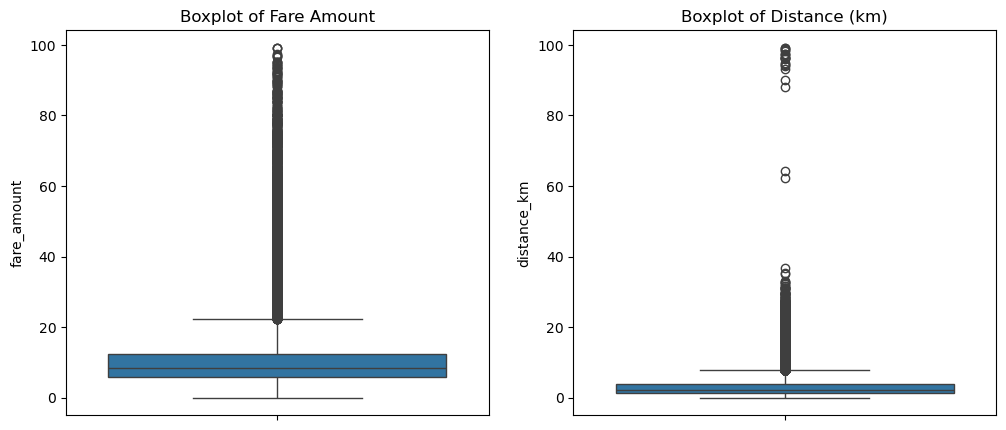

In [8]:
# 2. Identify outliers
# Visualize 'fare_amount' and 'distance_km' distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(df['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.subplot(1, 2, 2)
sns.boxplot(df['distance_km'])
plt.title('Boxplot of Distance (km)')
plt.show()

In [9]:
# Remove outliers based on z-scores for 'fare_amount' and 'distance_km'
from scipy import stats
df = df[(np.abs(stats.zscore(df[['fare_amount', 'distance_km']])) < 3).all(axis=1)]


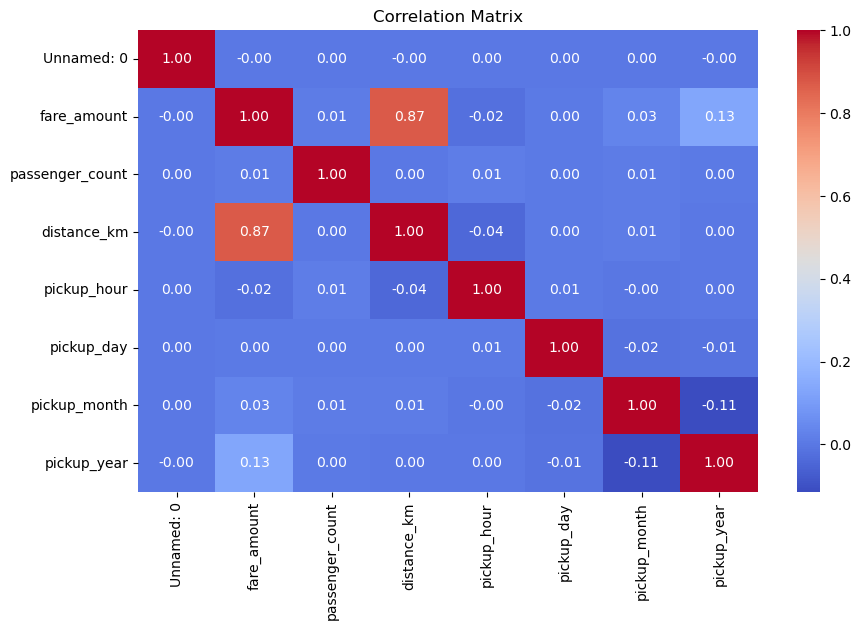

In [10]:
# 3. Check correlation
# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
# 4. Implement Linear Regression and Random Forest Regression models
# Define features and target variable
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Initialize and train the Random Forest Regression model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [12]:
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
# Predict on test set
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

# Calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [13]:
# Linear Regression evaluation
r2_linear, rmse_linear = evaluate_model(y_test, y_pred_linear)
print("Linear Regression:")
print(f"R^2 Score: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")

Linear Regression:
R^2 Score: 0.7740
RMSE: 2.9062


In [14]:
# Random Forest Regression evaluation
r2_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)
print("\nRandom Forest Regression:")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Random Forest Regression:
R^2 Score: 0.7957
RMSE: 2.7631


In [15]:
# Visualization of predicted vs actual fare amount for both models
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted Fares')

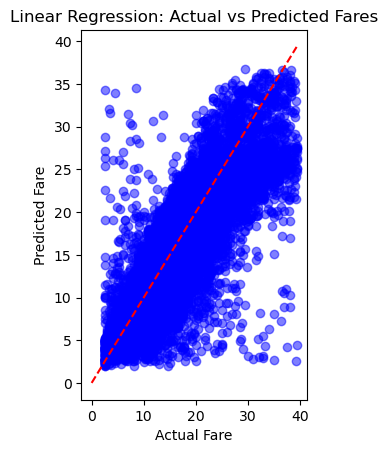

In [16]:
# Linear Regression Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Linear Regression: Actual vs Predicted Fares")


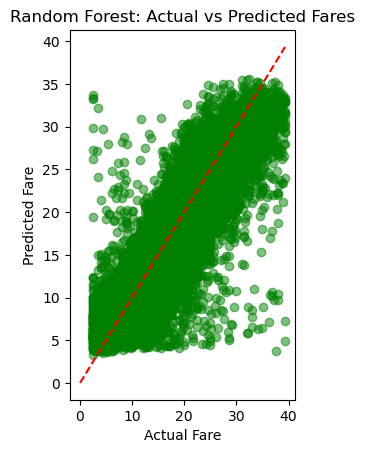

In [17]:
# Random Forest Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Actual vs Predicted Fares")

plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'legend_'

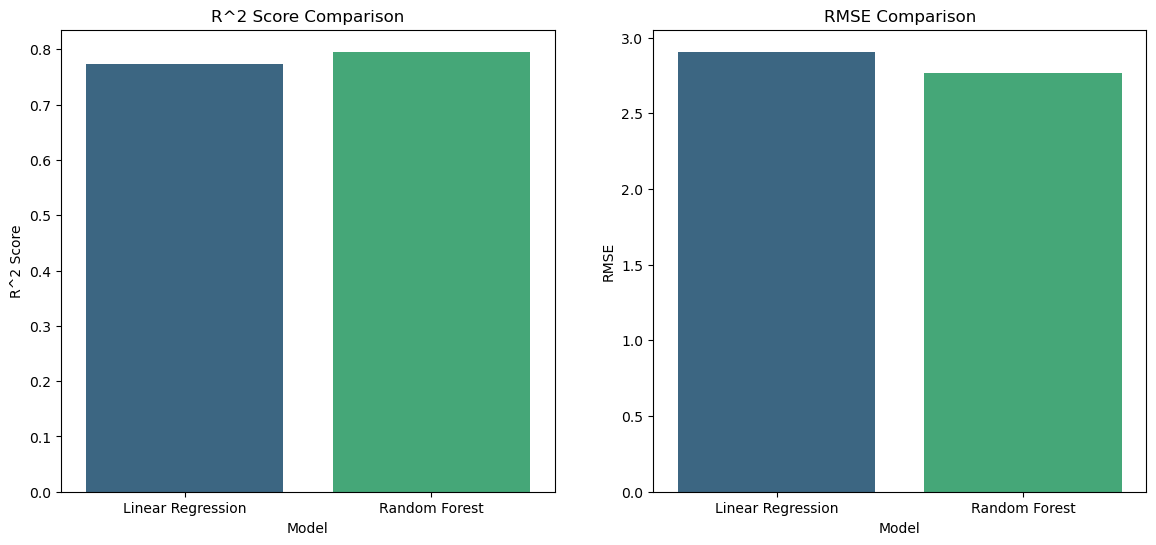

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R^2 Score': [r2_linear, r2_rf],
    'RMSE': [rmse_linear, rmse_rf]
})

plt.figure(figsize=(14, 6))

# R^2 Score
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R^2 Score', data=metrics, hue='Model', dodge=False, palette='viridis')
plt.title("R^2 Score Comparison")


# RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=metrics, hue='Model', dodge=False, palette='viridis')
plt.title("RMSE Comparison")
plt.legend_.remove()

plt.show()


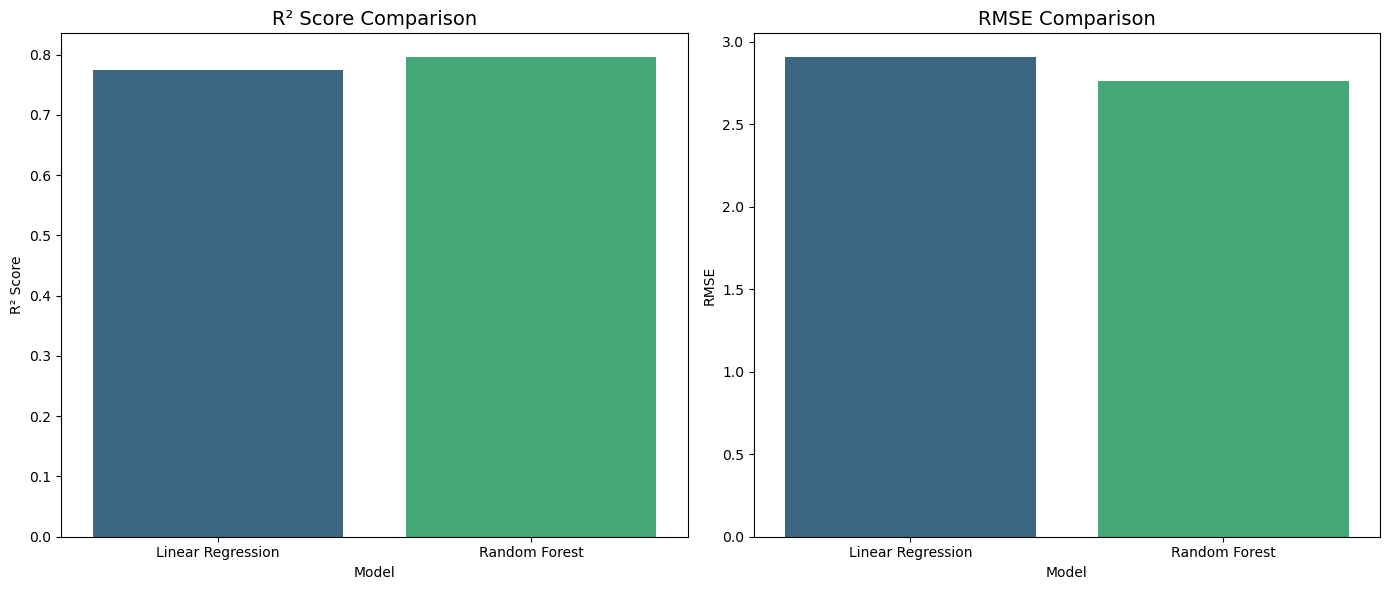


✅ Predictions added successfully!
   Unnamed: 0  fare_amount  passenger_count  distance_km  pickup_hour  \
0    24238194          7.5                1     1.681111           19   
1    27835199          7.7                1     2.454363           20   
2    44984355         12.9                1     5.039603           21   
3    25894730          5.3                3     1.661442            8   
4    17610152         16.0                5     4.483730           17   

   pickup_day  pickup_month  pickup_year  LinearPred  RandomForestPred  
0           7             5         2015    8.769105             7.790  
1          17             7         2009    7.960592             8.028  
2          24             8         2009   13.777405            12.546  
3          26             6         2009    6.060768             5.712  
4          28             8         2014   14.886667            16.010  


In [19]:
# Create metrics DataFrame
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R^2 Score': [r2_linear, r2_rf],
    'RMSE': [rmse_linear, rmse_rf]
})

# Plot comparison of R² and RMSE
plt.figure(figsize=(14, 6))

# R² Score Comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R^2 Score', hue='Model', data=metrics, palette='viridis', legend=False)
plt.title("R² Score Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("R² Score")

# RMSE Comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', hue='Model', data=metrics, palette='viridis', legend=False)
plt.title("RMSE Comparison", fontsize=14)
plt.xlabel("Model")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

# Add predictions to the dataset
solution = df.copy()
solution["LinearPred"] = linear_model.predict(df.drop('fare_amount', axis=1))
solution["RandomForestPred"] = random_forest_model.predict(df.drop('fare_amount', axis=1))

print("\n✅ Predictions added successfully!")
print(solution.head())


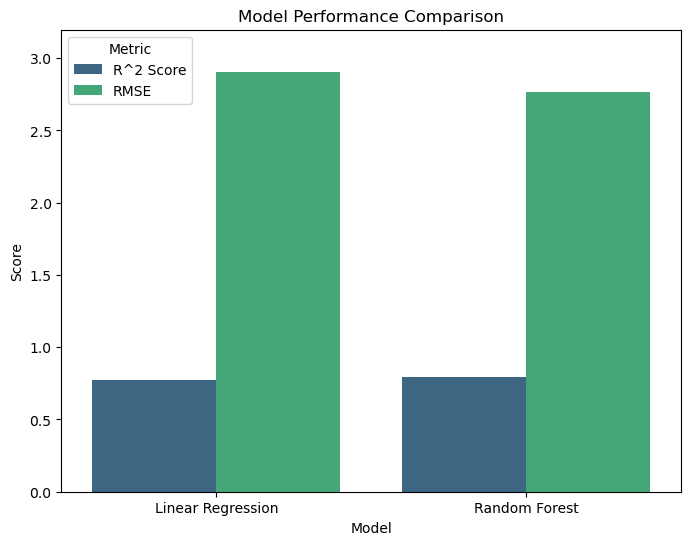

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data in long format for grouped barplot
metrics_long = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Linear Regression', 'Random Forest'],
    'Metric': ['R^2 Score', 'R^2 Score', 'RMSE', 'RMSE'],
    'Value': [r2_linear, r2_rf, rmse_linear, rmse_rf]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_long, palette='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, max(metrics_long['Value'])*1.1)  # Add some space above bars
plt.legend(title='Metric')
plt.show()
